# Bifurcation diagram of the `aln` model

In this notebook, we will discover how easy it is to draw bifurcation diagrams in `neurolib` using its powerful `BoxSearch` class.

Bifurcation diagrams are an important tool to understand a dynamical system, may it be a single neuron model or a whole-brain network. They show how a system behaves when certain parameters of the model are changed: whether the system transitions into an oscillation for example, or whethter the system remains in a fixed point (of sustained constant activity).

We will use this to draw a map of the `aln` model: Since the `aln` model consists of two populations of Adex neurons, we will change its inputs to the excitatory and to the inhibitory population independently and do so for two different values of spike-frequency adaptation strength $b$. We will measure the activity of the system and identify regions of oscillatory activity and discover bistable states, in which the system can be in two different stable states for the same set of parameters.

In [1]:
# change into the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

In [2]:
import logging
logger = logging.getLogger()
import warnings
warnings.filterwarnings("ignore")

#logger.setLevel(logging.DEBUG)
#logging.disable(logging.WARNING)
#logging.disable(logging.WARN)

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import neurolib.utils.functions as func
import neurolib.optimize.exploration.explorationUtils as eu
import neurolib.utils.devutils as du
from neurolib.utils.loadData import Dataset

In [4]:
plt.style.use("seaborn-white")
plt.rcParams['image.cmap'] = 'plasma'

## Create the model

In [ ]:
model = ALNModel()
model.params['dt'] = 0.1 # Integration time step, ms
model.params['duration'] = 20 * 1000 # Simulation time, ms

model.params['save_dt'] = 10.0 # 10 ms sampling steps for saving data, should be multiple of dt
model.params["tauA"] = 600.0 # Adaptation timescale, ms

### Measuring bistability

The `aln` model has a region of bistability, in which two states are stable at the same time: the low-activity *down-state*, and the high-activity *up-state*. We can find these states by constructing a stimulus, which uncovers the bistable nature of the system: Initially, we apply a negative push to the system, to make sure that it is in the *down-state*. We then relax this stimulus slowly and wait for the system to settle. We then apply a sharp push in order to reach the *up-state* and release the stimulus slowly back again. The difference of the two states after the stimulus has relaxed back to zero is a sign for bistability.

In [39]:
# we place the system in the bistable region
model.params['mue_ext_mean'] = 2.5
model.params['mui_ext_mean'] = 2.5

# construct a stimulus
rect_stimulus = func.construct_stimulus(stim="rect", duration=model.params.duration, dt=model.params.dt)
model.params['ext_exc_current'] = rect_stimulus * 5.0    
    
model.run()

Text(0, 0.5, 'Activity [Hz]')

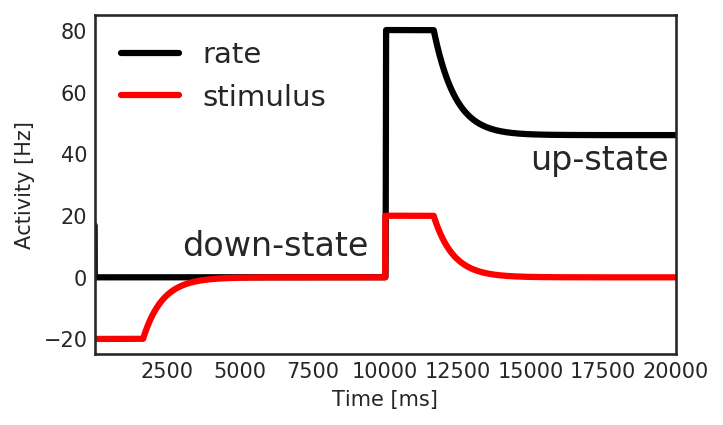

In [40]:
plt.figure(figsize=(5, 3), dpi=150)
plt.plot(model.t, model.output.T, lw = 3, c='k', label='rate')
plt.plot(model.t, rect_stimulus * 100, lw = 3, c='r', label="stimulus")
plt.text(3000, 7, 'down-state', fontsize=16)
plt.text(15000, 35, 'up-state', fontsize=16)
plt.legend(fontsize=14)
plt.xlim(1, model.t[-1])
plt.xlabel("Time [ms]")
plt.ylabel("Activity [Hz]")

### Define evaluation function

Let's construct a rather lengthy evaluation function which does exactly that, for every parameter configuration that we want to explore. We will also measure other things like the *dominant frequency* and amplitude of oscillations and the maximum rate of the excitatory population.

In [11]:
def evaluateSimulation(traj):
    # get the model from the trajectory using `search.getModelFromTraj(traj)`
    model = search.getModelFromTraj(traj)
    # initiate the model with random initial contitions
    model.randomICs()
    defaultDuration = model.params['duration']
    
    # -------- stage wise simulation --------
    
    # Stage 3: full and final simulation
    # ---------------------------------------    
    model.params['duration'] = defaultDuration
    
    # construct a rectified stimulus for detecting up and down-states
    rect_stimulus = func.construct_stimulus(stim="rect", duration=model.params.duration, dt=model.params.dt)
    model.params['ext_exc_current'] = rect_stimulus * 5.0    
    
    model.run()
    
    # measure difference between up and down-state after stimulus
    state_length = model.params.duration / 4 # length of the window after the stimulus has relaxed back to zero
    
    down_window = (defaultDuration/2-state_length<model.t) & (model.t<defaultDuration/2) # time period in ms where we expect the down-state
    up_window = (defaultDuration-state_length<model.t) & (model.t<defaultDuration) # and up state
    up_state_rate = np.mean(model.output[:, up_window])
    down_state_rate = np.mean(model.output[:, down_window])
    up_down_difference = up_state_rate - down_state_rate
        
    max_amp_output = np.max(
          np.max(model.output[:, up_window], axis=1) 
        - np.min(model.output[:, up_window], axis=1)
    )
    max_output = np.max(model.output[:, up_window])
     
    max_amp_output = np.max(
          np.max(model.output[:, up_window], axis=1) 
        - np.min(model.output[:, up_window], axis=1)
    )
    max_output = np.max(model.output[:, up_window])
    
    model_frs, model_pwrs = func.getMeanPowerSpectrum(model.output[:, up_window], dt=model.params.dt, maxfr=40, spectrum_windowsize=5)
    domfr = model_frs[np.argmax(model_pwrs)]    
    max_power = np.max(model_pwrs)     

    result = {
        "max_output": max_output, 
        "max_amp_output" : max_amp_output,
        "max_power" : max_power,
        #"model_pwrs" : model_pwrs,
        #"output": model.output[:, ::int(model.params['save_dt']/model.params['dt'])],
        "domfr" : domfr,
        "up_down_difference" : up_down_difference
    }
    
    search.saveOutputsToPypet(result, traj)
    return    

Let's now define the parameter space over which we want to serach. We apply a grid search over the mean external input parameters to the excitatory and the inhibitory population `mue_ext_mean`/`mui_ext_mean` and do this for two values of spike-frequency adapation strength $b$, once without and once with adaptation.

### Exploration parameters

In [ ]:
# low number of parameters for testing:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0.0, 4, 2), 
                             "mui_ext_mean": np.linspace(0.0, 4, 2),
                              "b": [0.0, 20.0]
                             })
# real: 
# parameters = ParameterSpace({"mue_ext_mean": np.linspace(0.0, 4, 41), 
#                              "mui_ext_mean": np.linspace(0.0, 4, 41),
#                               "b": [0.0, 20.0]
#                              })
search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename='example-1.3-aln-bifurcation-diagram.hdf')

### Run

In [ ]:
search.run()

## Analysis

In [ ]:
search.loadResults()

In [45]:
#search.loadDfResults()

In [46]:
#search.aggregateResultsToDfResults(fillna=True)

### The results dataframe

In [47]:
search.dfResults

,mue_ext_mean,mui_ext_mean,b,up_down_difference,max_power,max_output,max_amp_output,domfr
0,0.0,0.0,0.0,0.001380,3.442557e-07,0.044174,0.005433,0.200004
1,0.0,0.0,20.0,0.000897,8.340692e-08,0.039334,0.002471,0.200004
2,0.0,0.1,0.0,0.000728,1.000060e-07,0.028010,0.003382,0.200004
3,0.0,0.1,20.0,0.000511,2.994992e-08,0.025492,0.001504,0.200004
4,0.0,0.2,0.0,0.000403,2.921720e-08,0.013855,0.001578,0.200004
...,...,...,...,...,...,...,...,...
3357,4.0,3.8,20.0,0.001967,3.909186e-06,29.976812,0.038180,0.200004
3358,4.0,3.9,0.0,0.048964,4.306478e-04,93.642952,0.191476,0.200004
3359,4.0,3.9,20.0,0.001966,3.910924e-06,29.939057,0.038224,0.200004
3360,4.0,4.0,0.0,0.048968,4.307296e-04,93.572076,0.191494,0.200004


### Plotting 2D bifurcation diagrams

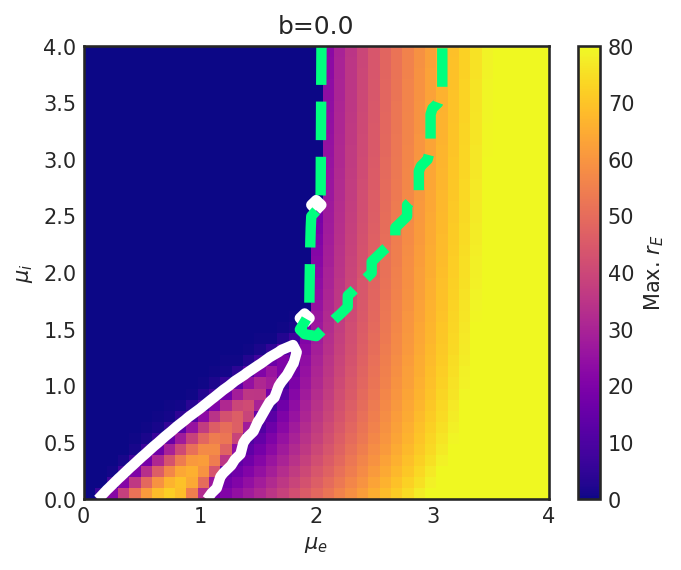

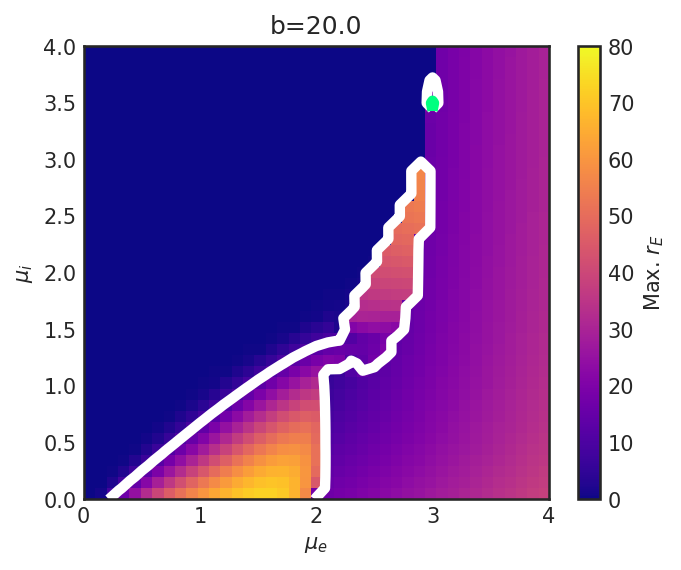

In [48]:
plot_key_label = "Max. $r_E$"
eu.plotExplorationResults(search.dfResults, 
                          par1=['mue_ext_mean', '$\mu_e$'], 
                          par2=['mui_ext_mean', '$\mu_i$'], 
                          by=['b'], 
                          plot_key='max_output',
                          plot_clim=[0.0, 80.0],
                          nan_to_zero=False,
                          plot_key_label=plot_key_label, 
                          one_figure=False,
                          contour=["max_amp_output", "up_down_difference"],
                          contour_color=[['white'], ['springgreen']],
                          contour_levels=[[10], [10]],
                          contour_alpha=[1.0, 1.0],
                          contour_kwargs={0 : {"linewidths" : (5,)}, 1 : {"linestyles" : "--", "linewidths" : (5,)}},
                          #alpha_mask="relative_amplitude_BOLD",
                          mask_threshold=0.1,
                          mask_alpha=0.2)